In [17]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import gc

from sklearn.preprocessing import LabelEncoder

In [25]:
import os
import pandas as pd
import librosa

BASE_DIR = '/Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/'
RAW_DATA_DIR = os.path.join(BASE_DIR, 'raw_data')
TRAIN_CSV_PATH = os.path.join(RAW_DATA_DIR, 'cv-valid-train.csv')

# # 관심 액센트 및 기타 조건 (예시)
# accents = ['canada', 'england', 'indian', 'scotland']
# # accents = ['canada', 'england', 'indian', 'australia']

# CSV 로드 및 기본 필터링 (gender, accent 존재 여부, 관심 액센트, 존재하는 경로 체크)
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_train = df_train.dropna(subset=['gender', 'accent'])
# df_train = df_train[df_train['accent'].isin(accents)]
# 이미 파일 존재 여부 체크 (파일 경로 기준)
df_train = df_train[df_train['filename'].apply(lambda x: os.path.exists(os.path.join(RAW_DATA_DIR, x)))]
df_train = df_train[['filename', 'gender', 'accent', 'age']].copy()

# print(df_train.head(20))
# print("초기 CSV의 파일 존재 filtered accent counts:")
print(df_train['accent'].value_counts())

# # --- 손상된 오디오 파일(유효하지 않은 파일) 확인 및 삭제 ---
# def is_audio_file_valid(file_path):
#     try:
#         # sr=None: 원본 샘플링 레이트로 로드 (불필요한 리샘플링 방지)
#         audio, sr = librosa.load(file_path, sr=None)
#         return True
#     except Exception as e:
#         return False

# # 손상된 파일 목록 수집
# invalid_files = []
# for idx, row in df_train.iterrows():
#     fpath = os.path.join(RAW_DATA_DIR, row['filename'])
#     if not is_audio_file_valid(fpath):
#         invalid_files.append(row['filename'])

# print(f"손상된(유효하지 않은) 파일 수: {len(invalid_files)}")

# # CSV에서 손상된 파일 제거
# df_train_clean = df_train[~df_train['filename'].isin(invalid_files)].copy()

# # 실제 디스크에서도 손상된 파일 삭제 (원한다면 실행)
# for filename in invalid_files:
#     fpath = os.path.join(RAW_DATA_DIR, filename)
#     try:
#         os.remove(fpath)
#         print(f"삭제 완료: {fpath}")
#     except Exception as e:
#         print(f"{fpath} 삭제 실패: {str(e)}")

# print("\n최종 CSV (손상 파일 제거 후) accent counts:")
# print(df_train_clean['accent'].value_counts())

# # df_train_clean을 이후의 파이프라인으로 사용하시면 됩니다.


accent
us                29777
england           14648
indian             4382
australia          4019
canada             3835
scotland           1541
african            1133
newzealand         1129
ireland             928
philippines         316
wales               256
bermuda             191
malaysia            182
singapore           122
hongkong             99
southatlandtic       81
Name: count, dtype: int64


In [18]:
ACCENTS_OF_INTEREST = ['canada', 'england', 'indian', 'scotland']
BASE_DIR = '/Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/'
RAW_DATA_DIR = os.path.join(BASE_DIR, 'raw_data')

# CSV 로드 및 기본 필터링
TRAIN_CSV_PATH = os.path.join(RAW_DATA_DIR, 'cv-valid-train.csv')
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_train = df_train.dropna(subset=['gender', 'accent'])
df_train = df_train[df_train['accent'].isin(ACCENTS_OF_INTEREST)]
df_train = df_train[df_train['filename'].apply(lambda x: os.path.exists(os.path.join(RAW_DATA_DIR, x)))]
df_train = df_train[['filename', 'gender', 'accent', 'age']].copy()

print("File-existence filtered accent counts:")
print(df_train['accent'].value_counts())

File-existence filtered accent counts:
accent
england     14648
indian       4382
canada       3835
scotland     1541
Name: count, dtype: int64


In [19]:
import os
import pandas as pd

# RAW_DATA_DIR와 ACCENTS_OF_INTEREST가 미리 정의되어 있어야 합니다.
# 예:
# RAW_DATA_DIR = '/path/to/raw_data'
# ACCENTS_OF_INTEREST = ['england', 'indian', 'canada', 'scotland']

# CSV 파일 경로 설정
TEST_CSV_VALID_PATH = os.path.join(RAW_DATA_DIR, 'cv-valid-test.csv')
TEST_CSV_OTHER_PATH = os.path.join(RAW_DATA_DIR, 'cv-other-test.csv')
TEST_CSV_DEV_PATH = os.path.join(RAW_DATA_DIR, 'cv-other-dev.csv')
TRAIN_CSV_OTHER_PATH = os.path.join(RAW_DATA_DIR, 'cv-other-train.csv')

# CSV 파일 읽기
df_valid = pd.read_csv(TEST_CSV_VALID_PATH)
df_other = pd.read_csv(TEST_CSV_OTHER_PATH)
df_dev = pd.read_csv(TEST_CSV_DEV_PATH)
df_train_other = pd.read_csv(TRAIN_CSV_OTHER_PATH)

# 모든 데이터프레임을 하나로 통합 (행 결합)
df_test = pd.concat([df_valid, df_other, df_dev, df_train_other], ignore_index=True)

# gender 결측값 제거
df_test = df_test.dropna(subset=['gender'])

# 관심 있는 accent만 필터링 (ACCENTS_OF_INTEREST에 포함된 값만 남김)
df_test = df_test[df_test['accent'].isin(ACCENTS_OF_INTEREST)]

# accent 결측값 제거
df_test = df_test.dropna(subset=['accent'])

# RAW_DATA_DIR 내에 해당 파일이 존재하는 행만 남김
df_test = df_test[df_test['filename'].apply(lambda x: os.path.exists(os.path.join(RAW_DATA_DIR, x)))]

# 필요한 열 선택
df_test = df_test[['filename', 'gender', 'accent', 'age']]

# 각 accent 별로 샘플의 수를 균일하게 맞추기 (가장 적은 샘플 수에 맞춰)
min_count = df_test['accent'].value_counts().min()
df_test_balanced = df_test.groupby('accent', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))

print("Balanced accent counts for test set:")
print(df_test_balanced['accent'].value_counts())


Balanced accent counts for test set:
accent
canada      1191
england     1191
indian      1191
scotland    1191
Name: count, dtype: int64


/var/folders/t3/6wjz0w9511d3t31xphnn6jbr0000gn/T/ipykernel_84224/1376500483.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby('accent', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))


In [20]:
MAX_AUG = 3   # 최대 augmentation 배수 (예: 최대 2배)

# 원본 dataframe 복사 (밸런싱에 사용할 임시 복사본)
df_temp = df_train.copy()

# (gender, age)별로 모든 accent가 나타나는 조합 선택
combo_counts = df_temp.groupby(['gender', 'age'])['accent'].nunique()
num_accents = df_temp['accent'].nunique()
valid_combos = combo_counts[combo_counts == num_accents].index.tolist()

# 새 balanced 그룹 저장용 리스트
balanced_dfs = []
resample_info_lines = []

# 각 (gender, age) 조합별로 처리
for gender, age in valid_combos:
    subset = df_temp[(df_temp['gender'] == gender) & (df_temp['age'] == age)]
    accent_counts = subset.groupby('accent').size()
    # 목표 T: 최소 그룹 수의 최대 MAX_AUG 배와, 해당 조합 내 가장 많은 그룹 수 중 작은 값
    T = min(accent_counts.max(), int(MAX_AUG * accent_counts.min()))
    
    for accent_val, group in subset.groupby('accent'):
        current_count = len(group)
        if current_count > T:
            # undersample: T개의 행만 선택, 각 행의 factor = 1
            balanced_group = group.sample(n=T, random_state=42)
            balanced_group['resample_factor'] = 1
            method = "undersample"
            float_factor = current_count / T  # 참고용
        elif current_count == T:
            balanced_group = group.copy()
            balanced_group['resample_factor'] = 1
            method = "balanced"
            float_factor = 1.0
        else:
            # oversample (augmentation)
            float_factor = T / current_count  # 예: 2.8
            int_part = int(float_factor)       # 예: 2
            frac_part = float_factor - int_part  # 예: 0.8
            balanced_group = group.copy()
            balanced_group['resample_factor'] = int_part  # 우선 모든 행에 int_part 할당
            partial_count = int(round(current_count * frac_part))
            if partial_count > 0 and partial_count <= current_count:
                idx_partial = np.random.choice(balanced_group.index, size=partial_count, replace=False)
                balanced_group.loc[idx_partial, 'resample_factor'] = int_part + 1
            method = f"oversample (float_factor={float_factor:.2f})"
        
        info_line = (f"Gender={gender}, Age={age}, Accent={accent_val}, "
                     f"Original={current_count}, T={T}, Final avg factor={balanced_group['resample_factor'].mean():.2f} ({method})")
        resample_info_lines.append(info_line)
        balanced_dfs.append(balanced_group)

# 최종 balanced DataFrame
df_balanced_final = pd.concat(balanced_dfs, ignore_index=True)

# 결과 정보를 파일로 저장
output_dir = os.path.join(BASE_DIR, "data")
os.makedirs(output_dir, exist_ok=True)
info_txt_path = os.path.join(output_dir, "train_dataset_info.txt")
with open(info_txt_path, "w") as f:
    f.write("Resample Factor Information:\n")
    for line in resample_info_lines:
        f.write(line + "\n")
print("Resample factor information saved to", info_txt_path)

# 최종 weighted sample 수 계산: 각 accent별 resample_factor의 합
weighted_totals = df_balanced_final.groupby('accent')['resample_factor'].sum()
print("\nWeighted sample totals per accent (should be equal):")
print(weighted_totals)

Resample factor information saved to /Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/data/train_dataset_info.txt

Weighted sample totals per accent (should be equal):
accent
canada      2073
england     2073
indian      2073
scotland    2073
Name: resample_factor, dtype: int64


In [21]:
import os
import pandas as pd


# CSV 불러오기
df_balanced = df_balanced_final.copy()

# 각 accent에 대해 resample_factor 값의 합계를 계산하면, augmentation 적용 후 총 샘플 수가 됩니다.
accent_totals = df_balanced.groupby('accent')['resample_factor'].sum()
print("\nTotal samples per accent (weighted by resample_factor):")
print(accent_totals)

# 각 그룹의 augmentation factor 평균 확인 (예: 목표 oversample 배수)
avg_factor = df_balanced.groupby('accent')['resample_factor'].mean()
print("\nAverage augmentation factor per accent:")
print(avg_factor)





Total samples per accent (weighted by resample_factor):
accent
canada      2073
england     2073
indian      2073
scotland    2073
Name: resample_factor, dtype: int64

Average augmentation factor per accent:
accent
canada      1.353133
england     1.000000
indian      1.727500
scotland    2.311037
Name: resample_factor, dtype: float64


In [23]:
# Weighted confusion matrix by augmentation factor (Accent x Age)
weighted_confusion_age = pd.pivot_table(
    df_balanced, 
    index='accent', 
    columns='age', 
    values='resample_factor', 
    aggfunc='sum', 
    fill_value=0
)
print("\nAccent x Age Confusion Matrix:")
print(weighted_confusion_age)

# Weighted confusion matrix by augmentation factor (Accent x Gender)
weighted_confusion_gender = pd.pivot_table(
    df_balanced, 
    index='accent', 
    columns='gender', 
    values='resample_factor', 
    aggfunc='sum', 
    fill_value=0
)
print("\nAccent x Gender Confusion Matrix:")
print(weighted_confusion_gender)


Accent x Age Confusion Matrix:
age       fifties  fourties  sixties  teens  thirties  twenties
accent                                                         
canada        150       135      147     75      1071       495
england       150       135      147     75      1071       495
indian        150       135      147     75      1071       495
scotland      150       135      147     75      1071       495

Accent x Gender Confusion Matrix:
gender    female  male
accent                
canada       186  1887
england      186  1887
indian       186  1887
scotland     186  1887


In [91]:
import os
import pandas as pd

# cv-other-train.csv 파일에서 validation candidate 데이터 읽기
VALID_CSV_PATH = os.path.join(RAW_DATA_DIR, 'cv-other-train.csv')
df_valid_candidate = pd.read_csv(VALID_CSV_PATH)

# training set과 동일한 filtering 적용
df_valid_candidate = df_valid_candidate.dropna(subset=['gender', 'accent'])
df_valid_candidate = df_valid_candidate[df_valid_candidate['accent'].isin(ACCENTS_OF_INTEREST)]
df_valid_candidate = df_valid_candidate[
    df_valid_candidate['filename'].apply(lambda x: os.path.exists(os.path.join(RAW_DATA_DIR, x)))
]
df_valid_candidate = df_valid_candidate[['filename', 'gender', 'accent', 'age']].copy()

# 각 악센트별로 최대 500개 샘플 추출 (해당 악센트 그룹에 500개 미만이면 전체 사용)
balanced_valid_groups = []
for accent, group in df_valid_candidate.groupby('accent'):
    n_samples = 500 if len(group) >= 500 else len(group)
    sampled_group = group.sample(n=n_samples, random_state=42)
    balanced_valid_groups.append(sampled_group)

# 균형 잡힌 validation DataFrame 생성
df_valid = pd.concat(balanced_valid_groups, ignore_index=True)

# 각 악센트별 샘플 수 출력
accent_counts = df_valid['accent'].value_counts()
print("Accent counts in validation set:")
print(accent_counts)


Accent counts in validation set:
accent
canada      500
england     500
indian      500
scotland    500
Name: count, dtype: int64


In [92]:
from sklearn.preprocessing import LabelEncoder
import os

# Create a label encoder and fit on the 'accent' column of df_balanced
label_encoder = LabelEncoder()
df_balanced['accent_encoded'] = label_encoder.fit_transform(df_balanced['accent'])

# Use the same label encoder to transform the 'accent' column of df_valid
df_valid['accent_encoded'] = label_encoder.transform(df_valid['accent'])

df_test_balanced['accent_encoded'] = label_encoder.fit_transform(df_test_balanced['accent'])

# Print counts for verification
print("Balanced dataset accent counts:")
print(df_balanced['accent_encoded'].value_counts())
print("\nValidation dataset accent counts:")
print(df_valid['accent_encoded'].value_counts())
print("\nLabel classes:")
print(label_encoder.classes_)

# Append the accent label mapping information to the existing info text file
txt_out_path = os.path.join(BASE_DIR, 'data', 'label_mapping_info.txt')
with open(txt_out_path, "a") as f:  # open in append mode
    f.write("\nAccent Label Mapping:\n")
    for encoded_value, accent in enumerate(label_encoder.classes_):
        f.write(f"{encoded_value}: {accent}\n")

print("Accent label mapping appended to", txt_out_path)


Balanced dataset accent counts:
accent_encoded
1    2073
0    1532
2    1200
3     897
Name: count, dtype: int64

Validation dataset accent counts:
accent_encoded
0    500
1    500
2    500
3    500
Name: count, dtype: int64

Label classes:
['canada' 'england' 'indian' 'scotland']
Accent label mapping appended to /Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/data/label_mapping_info.txt


In [93]:
# Save the balanced validation DataFrame to a CSV file
df_valid_csv_path = os.path.join(output_dir, 'df_valid.csv')
df_valid.to_csv(df_valid_csv_path, index=False)
print("Balanced validation DataFrame saved to", df_valid_csv_path)

# Save the balanced DataFrame to a CSV file in the same directory
df_balanced_csv_path = os.path.join(output_dir, 'df_train_balanced.csv')
df_balanced.to_csv(df_balanced_csv_path, index=False)
print("Balanced DataFrame saved to", df_balanced_csv_path)

# Save the df_test DataFrame to a CSV file
output_dir = os.path.join(BASE_DIR, 'data')
os.makedirs(output_dir, exist_ok=True)
df_test_csv_path = os.path.join(output_dir, 'df_test.csv')
df_test_balanced.to_csv(df_test_csv_path, index=False)
print("Test DataFrame saved to", df_test_csv_path)

Balanced validation DataFrame saved to /Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/data/df_valid.csv
Balanced DataFrame saved to /Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/data/df_train_balanced.csv
Test DataFrame saved to /Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/data/df_test.csv


Completed df_balance, df_valid, and df_test

## MFCC

In [94]:
import random
import numpy as np
import librosa
from scipy.signal import butter, lfilter

def lowpass_filter(data, sr, cutoff=5000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)

def augment_audio(audio, sr):
    """
    Return a list of augmented audio signals using different augmentation techniques.
    Augmentation techniques include:
      - Pitch shift: random semitone shift between -2 and 2
      - Time stretch: random rate between 0.9 and 1.1
      - Noise addition: add small random Gaussian noise
    """
    augmented_audios = []
    
    # Pitch shift
    try:
        semitones = np.random.uniform(-2, 2)
        pitch_shifted = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=semitones)
        augmented_audios.append(pitch_shifted)
    except Exception as e:
        print("Pitch shift error:", e)
    
    # Time stretch
    try:
        rate = np.random.uniform(0.75, 1.25)
        time_stretched = librosa.effects.time_stretch(y=audio, rate=rate)
        augmented_audios.append(time_stretched)
    except Exception as e:
        print("Time stretch error:", e)
    
    # Noise addition
    try:
        noise = np.random.randn(len(audio)) * 0.005  # Adjust noise level as needed
        noisy = audio + noise
        augmented_audios.append(noisy)
    except Exception as e:
        print("Noise addition error:", e)
    
    return augmented_audios


def extract_features_with_augmentation(file_path, h=12, aug_count=0):
    """
    Load an audio file, filter, and extract original MFCCs.
    Then generate 'aug_count' augmented versions and extract MFCCs for each.
    """
    try:
        audio, sr = librosa.load(file_path, sr=None, mono=True)
        audio = np.ravel(audio)  # ensure 1D
        audio_filt = lowpass_filter(audio, sr, cutoff=5000)
        
        win_length = int(0.025 * sr)
        hop_length = int(0.01 * sr)
        n_fft = win_length
        
        # original MFCC
        mfcc_orig = librosa.feature.mfcc(
            y=audio_filt,
            sr=sr,
            n_mfcc=h,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            window='hann'
        )
        outputs = [mfcc_orig]
        
        if aug_count > 0:
            aug_audios = augment_audio(audio_filt, sr)
            for i in range(aug_count):
                if aug_audios:
                    # pick one augmented version from the list
                    aug_audio = random.choice(aug_audios)
                    aug_audio = np.ravel(aug_audio)  # ensure 1D
                    mfcc_aug = librosa.feature.mfcc(
                        y=aug_audio,
                        sr=sr,
                        n_mfcc=h,
                        n_fft=n_fft,
                        hop_length=hop_length,
                        win_length=win_length,
                        window='hann'
                    )
                    outputs.append(mfcc_aug)
        return outputs
    except Exception as e:
        print(f"Error processing file {file_path}: {str(e)}")
        return []

def pad_or_truncate(feature_matrix, target_length):
    current_length = feature_matrix.shape[1]
    if current_length < target_length:
        return np.pad(feature_matrix, ((0, 0), (0, target_length - current_length)), mode='constant')
    else:
        return feature_matrix[:, :target_length]


In [95]:
import os
import gc
from tqdm import tqdm

# # --- Process Training Data with Augmentation ---
all_mfccs_train = []  # Augmented MFCC list (augmented samples will be added)
print("Extracting MFCC features and applying augmentation for training set:")

for idx, row in tqdm(df_balanced.iterrows(), total=len(df_balanced), desc="Train features"):
    file_path = os.path.join(RAW_DATA_DIR, row['filename'])
    # resample_factor를 읽습니다.
    try:
        factor = float(row.get('resample_factor', 1))
    except:
        factor = 1.0
    # 추가로 생성할 augmentation sample 수 = round(factor) - 1, (만약 음수가 나오면 0)
    aug_count = max(0, int(round(factor)) - 1)
    
    mfcc_list = extract_features_with_augmentation(file_path, h=12, aug_count=aug_count)
    # mfcc_list는 원본 + 추가 augmented MFCC들을 담은 리스트입니다.
    # 각 MFCC의 shape는 (h, time_frames)
    # 모든 MFCC sample들을 모두 추가합니다.
    all_mfccs_train.extend(mfcc_list)

# # --- Process Validation Data (원본만 사용) ---
all_mfccs_valid = []
print("Extracting MFCC features for validation set:")
for idx, row in tqdm(df_valid.iterrows(), total=len(df_valid), desc="Valid features"):
    file_path = os.path.join(RAW_DATA_DIR, row['filename'])
    mfcc = extract_features_with_augmentation(file_path, h=12, aug_count=0)
    if mfcc is not None:
        all_mfccs_valid.append(mfcc)

# --- Process Test Data (원본만 사용) ---
all_mfccs_test = []
print("Extracting MFCC features for test set:")
for idx, row in tqdm(df_test_balanced.iterrows(), total=len(df_test_balanced), desc="Test features"):
    file_path = os.path.join(RAW_DATA_DIR, row['filename'])
    mfcc = extract_features_with_augmentation(file_path, h=12, aug_count=0)
    if mfcc is not None:
        all_mfccs_test.append(mfcc)

gc.collect()




Extracting MFCC features for test set:


Test features: 100%|██████████| 4764/4764 [01:27<00:00, 54.22it/s]


4811

In [98]:
from tensorflow.keras.utils import to_categorical
# --- Helper function to flatten nested lists of MFCC arrays ---
def flatten_mfcc_list(mfcc_list):
    flat_list = []
    for item in mfcc_list:
        # If the item is a list, extend with its contents; else append the item itself
        if isinstance(item, list):
            flat_list.extend(item)
        else:
            flat_list.append(item)
    return flat_list

# --- Flatten the validation and test MFCC lists ---
all_mfccs_valid_flat = flatten_mfcc_list(all_mfccs_valid)
all_mfccs_test_flat = flatten_mfcc_list(all_mfccs_test)

# --- Determine a common target length for MFCC time frames ---
# We use the training set augmented samples only.
# all_lengths_train = [m.shape[1] for m in all_mfccs_train if m is not None]
median_time_frames = int(np.median(all_lengths_train))
print("Median time frames (train augmented):", median_time_frames)

# --- Pad or truncate each MFCC matrix to the median_time_frames ---
padded_mfccs_train = [pad_or_truncate(m, median_time_frames) for m in all_mfccs_train if m is not None]
padded_mfccs_valid = [pad_or_truncate(m, median_time_frames) for m in all_mfccs_valid_flat if m is not None]
padded_mfccs_test  = [pad_or_truncate(m, median_time_frames) for m in all_mfccs_test_flat if m is not None]

# --- Build the final training audio array ---
# Each MFCC sample is expanded to shape (1, h, median_time_frames)
X_audio_train = np.stack([np.expand_dims(m, axis=0) for m in padded_mfccs_train])
X_audio_valid = np.stack([np.expand_dims(m, axis=0) for m in padded_mfccs_valid])
X_audio_test  = np.stack([np.expand_dims(m, axis=0) for m in padded_mfccs_test])

# --- Build training labels considering augmentation counts ---
def build_labels(df, augmentation_counts):
    """
    Given a DataFrame and augmentation_counts (a list of total samples per original row),
    replicate the row's label accordingly.
    """
    labels = []
    for idx, row in df.iterrows():
        count = augmentation_counts[idx]
        labels.extend([row['accent_encoded']] * count)
    return np.array(labels)

# Create augmentation_counts list: for each row in df_balanced, the total samples generated = round(factor)
augmentation_counts = []
for idx, row in df_balanced.iterrows():
    try:
        factor = float(row.get('resample_factor', 1))
    except:
        factor = 1.0
    total = int(round(factor))
    augmentation_counts.append(total)

# Build y_train using the augmentation_counts; df_balanced should have the 'accent_encoded' column
y_train_rep = build_labels(df_balanced, augmentation_counts)
y_train = to_categorical(y_train_rep)

# For validation and test sets, assume the labels are taken directly from df_valid and df_test respectively.
y_valid_rep = df_valid['accent_encoded'].values
y_valid = to_categorical(y_valid_rep)
y_test_rep = df_test_balanced['accent_encoded'].values
y_test = to_categorical(y_test_rep)

print("Final training audio shape (with augmentation):", X_audio_train.shape)
print("Final training label shape:", y_train.shape)


Median time frames (train augmented): 380


In [ ]:
# --- Save the NPZ files ---
output_dir = os.path.join(BASE_DIR, "data")
os.makedirs(output_dir, exist_ok=True)

train_npz_path = os.path.join(output_dir, "train-dataset.npz")
np.savez_compressed(train_npz_path, X=X_audio_train, y=y_train)
print("Saved training dataset to", train_npz_path)

valid_npz_path = os.path.join(output_dir, "valid-dataset.npz")
np.savez_compressed(valid_npz_path, X=X_audio_valid, y=y_valid)
print("Saved validation dataset to", valid_npz_path)

test_npz_path = os.path.join(output_dir, "test-dataset.npz")
np.savez_compressed(test_npz_path, X=X_audio_test, y=y_test)
print("Saved test dataset to", test_npz_path)

gc.collect()

Saved test dataset to /Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/data/test-dataset.npz


0

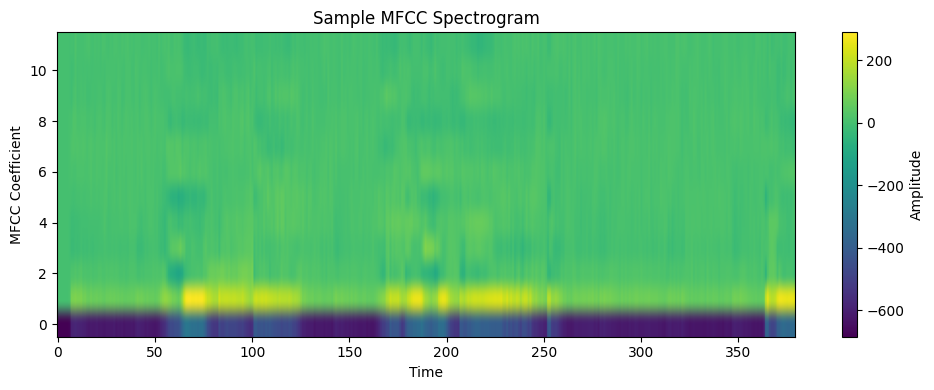

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os

BASE_DIR = '/Users/jeonsang-eon/ECE6254-Voice-Feature-Extraction/'

# Load the validation dataset
output_dir = os.path.join(BASE_DIR, "data_in_en_ca_scot_result")
valid_npz_path = os.path.join(output_dir, "valid-dataset.npz")
valid_data = np.load(valid_npz_path)

X_valid = valid_data["X"]
y_valid = valid_data["y"]

# Sample one MFCC spectrogram
sample_idx = np.random.randint(len(X_valid))
sample_mfcc = X_valid[sample_idx]

# If the MFCC shape is (1, n_mfcc, time) due to channel dimension, squeeze it
if sample_mfcc.ndim == 3 and sample_mfcc.shape[0] == 1:
    sample_mfcc = np.squeeze(sample_mfcc, axis=0)

# Plot the MFCC spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(sample_mfcc, aspect='auto', origin='lower', cmap='viridis')
plt.title(f"Sample MFCC Spectrogram")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficient")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()
